# Data Analysis Report for Supertrail

**Date:** February 18, 2025

---

## Introduction

The objective of this assignment was to analyze customer purchase data to derive insights related to product sampling and conversion rates. The dataset includes details such as customer IDs, order dates, product names, quantities, selling prices, brands, and product types. The analysis focuses on three primary aspects:

1. **Brand Attachment:** Evaluating the correlation between receiving a sample and subsequent purchases from the same brand.
2. **Product Attachment:** Measuring customer engagement with sample products that lead to the purchase of their corresponding parent products.
3. **Time to Conversion:** Calculating the time interval from receiving a sample to making the first conversion purchase.

This report leverages mathematical definitions of the metrics and visualizations to provide actionable business insights for Supertrail.

---

## Data Preparation and Methodology

Before computing the metrics, the datasets were loaded and cleaned. Key steps included:

- **Data Import and Conversion:**
  - Loading the orders and product mapping datasets.
  - Converting date fields to datetime objects for accurate time calculations.
  - Casting product IDs to numeric types to ensure proper matching between sample products and parent products.
  
- **Flagging Sample Orders:**
  - Orders were flagged as *sample* based on multiple criteria:
    - If the `productType` was explicitly marked as "Sample".
    - If the `productName` contained the term "sample" (case-insensitive).
    - If the `productId` existed in the sample product mapping.

These steps ensured that the analysis was performed on a high-quality, well-prepared dataset.

---

## Task 1: Analyze Brand Attachment

### Metric Definition

**Brand Loyalty** is defined mathematically as:

$$
\text{Brand Loyalty} = \frac{\text{Number of customers who received a sample and later purchased from the same brand}}{\text{Total number of customers who received a sample of that brand}}
$$

If we let:
- $n$ be the number of unique customers who received a sample from a brand,
- $m$ be the number of those customers who later made a purchase from that same brand,

then:

$$
\text{Brand Loyalty} = \frac{m}{n}
$$

### Methodology

- For each sample order, we checked if a customer made a subsequent purchase from the same brand (after the sample order date).
- We aggregated the results at the brand level to compute the overall conversion ratio.

---

## Task 2: Analyze Product Attachment

### Metric Definition

**Product Engagement** is calculated as:

$$
\text{Product Engagement (\%)} = \left( \frac{\text{Number of customers who received a sample and later purchased the corresponding parent product}}{\text{Total number of customers who received that sample}} \right) \times 100
$$

Let:
- $n$ be the total number of customers who received a specific sample product,
- $m$ be the number of those customers who later purchased the parent product,

then:

$$
\text{Product Engagement (\%)} = \left( \frac{m}{n} \right) \times 100
$$

### Methodology

- Sample orders were merged with the product mapping data to match each sample with its corresponding parent product.
- A conversion check was performed for each sample to determine if the customer later purchased the parent product.
- The metric was then calculated for each sample product.

---

## Task 3: Calculate Time to Conversion

### Metric Definition

**Time to Conversion** is the elapsed time between the sample order and the first subsequent purchase of the corresponding parent product. It is computed as:

$$
\text{Conversion Time (hours)} = \text{Time Difference (in hours)}
$$

To convert hours to days, we use:

$$
\text{Conversion Time (days)} = \frac{\text{Conversion Time (hours)}}{24}
$$

### Methodology

- For each sample order, the time until the first parent product purchase by the same customer was computed.
- Average and median conversion times were calculated to understand the overall conversion speed.
- The distribution of conversion times was visualized using a histogram with Kernel Density Estimation (KDE).

For example, if the average conversion time was calculated as 2263.65 hours, then in days it is:

$$
\text{Average Conversion Time (days)} = \frac{2263.65}{24} \approx 94.32 \text{ days}
$$

Similarly, the median conversion time in hours and days can be computed in the same manner.

---


# Load the datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

orders_df = pd.read_excel('Analyst_Assignment.xlsx', sheet_name='sample_customer_orders')
mapping_df = pd.read_excel('Analyst_Assignment.xlsx', sheet_name='sampleProductMapping')

# Data preparation

In [2]:
#  Prepare the orders data
# Rename vendor to brand (if needed) to match assignment terminology
orders_df.rename(columns={'vendor': 'brand'}, inplace=True)

# Convert order date column to datetime
orders_df["Order_date"] = pd.to_datetime(orders_df["Order_date"])

# Convert productId to string to ensure proper matching (if necessary)
orders_df["productId"] = orders_df["productId"].astype('Int64')
mapping_df["sampleProductId"] = mapping_df["sampleProductId"].astype('Int64')
mapping_df["parentProductId"] = mapping_df["parentProductId"].astype('Int64')


In [3]:
# Flag orders that are samples or parent product purchases
orders_df['is_sample'] = orders_df['productId'].isin(mapping_df['sampleProductId'])
orders_df['is_parent'] = orders_df['productId'].isin(mapping_df['parentProductId'])


In [4]:
orders_df.to_excel("final_data.xlsx", index=False)

In [5]:
#sample_orders = orders_df[orders_df["is_sample"]].copy()
#non_sample_orders = orders_df[~orders_df["is_sample"]].copy()
#sample_orders.shape

# Separate sample orders from the rest for analysis using multiple criteria

In [6]:

sample_orders = orders_df[
    (orders_df["is_sample"]) |
    (orders_df["productType"].str.lower() == "sample") |
    (orders_df["productName"].str.contains("sample", case=False, na=False))
].copy()

non_sample_orders = orders_df[~(
    (orders_df["is_sample"]) |
    (orders_df["productType"].str.lower() == "sample") |
    (orders_df["productName"].str.contains("sample", case=False, na=False))
)].copy()

In [7]:
sample_orders.shape

(89789, 12)

# TASK 1: Analyze Brand Attachment

In [8]:
# Function to check brand conversion
def check_brand_conversion(customer, brand, sample_date):
    # Filter orders placed after the sample order for this customer.
    subsequent_orders = orders_df[(orders_df['customer_id'] == customer) & 
                                  (orders_df['Order_date'] > sample_date)]
    # Check if any of these orders are from the same brand.
    return (subsequent_orders['brand'] == brand).any()


In [9]:
# --- Brand Loyalty ---
# Using the definition: 
# Brand Loyalty = (Number of customers who got a sample and later purchased from that brand) / (Total number of customers who received a sample of that brand)
sample_orders['brand_converted'] = sample_orders.apply(lambda row: check_brand_conversion(row['customer_id'], row['brand'], row['Order_date']), axis=1)

# Calculate brand loyalty for each brand using unique customers.
brand_stats = sample_orders.groupby('brand').agg(
    sample_customers=('customer_id', lambda x: x.nunique()),
    converted_customers=('brand_converted', lambda x: x[x==True].count())
).reset_index()
brand_stats['brand_loyalty'] = brand_stats['converted_customers'] / brand_stats['sample_customers']
print("Brand Loyalty Metrics:")
print(brand_stats)

Brand Loyalty Metrics:
             brand  sample_customers  converted_customers  brand_loyalty
0    A plus A pets                 7                    0       0.000000
1           Aeolus                 3                    0       0.000000
2          Applaws               161                   57       0.354037
3             BLEP               281                   43       0.153025
4    Bark Out Loud              1208                  222       0.183775
..             ...               ...                  ...            ...
109         Trixie               335                   99       0.295522
110           Wahl                 8                    0       0.000000
111        Whiskas               468                  497       1.061966
112        Wiggles                 2                    1       0.500000
113         Woofur                 3                    0       0.000000

[114 rows x 4 columns]


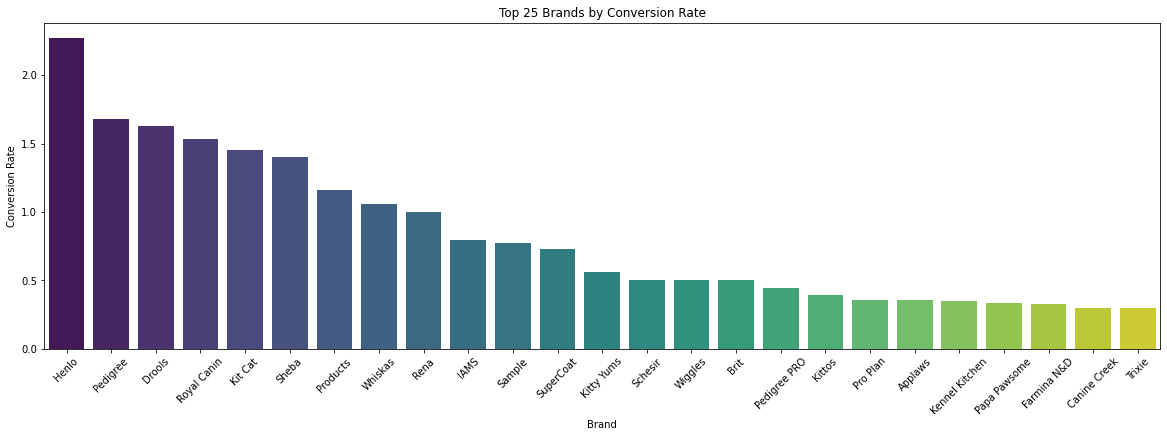

In [35]:
# Sort and get top 5 brands by conversion rate
top25_brands = brand_stats.sort_values(by='brand_loyalty', ascending=False).head(25)

plt.figure(figsize=(20, 6))
sns.barplot(data=top25_brands, x='brand', y='brand_loyalty', palette='viridis')
plt.title('Top 25 Brands by Conversion Rate')
plt.xlabel('Brand')
plt.ylabel('Conversion Rate')
plt.ylim
plt.xticks(rotation=45)
plt.show()

In [37]:
top25_brands

,brand,sample_customers,converted_customers,brand_loyalty,highlight
52,Henlo,6199,14060,2.268108,False
82,Pedigree,3919,6589,1.681296,False
27,Drools,6367,10382,1.630595,False
98,Royal Canin,3336,5106,1.530576,False
63,Kit Cat,2027,2950,1.455353,False
103,Sheba,2554,3581,1.402114,False
93,Products,590,683,1.157627,False
111,Whiskas,468,497,1.061966,False
97,Rena,2,2,1.000000,False
57,IAMS,1390,1103,0.793525,False


# TASK 2: Analyze Product Attachment

In [68]:
# Merge sample_orders with mapping_df to get the corresponding parent product ID.
sample_orders = sample_orders.merge(mapping_df, left_on='productId', right_on='sampleProductId', how='left')


In [69]:
# Function to check product (parent) conversion
def check_product_conversion(customer, parent_id, sample_date):
    subsequent_orders = orders_df[(orders_df['customer_id'] == customer) &
                                  (orders_df['Order_date'] > sample_date)]
    # Look for an order with the corresponding parent product.
    return (subsequent_orders['productId'] == parent_id).any()

In [70]:
# --- Product Engagement ---
# Using the definition:
# Product Engagement = (Number of customers who got a sample and later purchased the corresponding parent product) / (Total number of customers who received that sample)
sample_orders['product_converted'] = sample_orders.apply(lambda row: check_product_conversion(row['customer_id'], row['parentProductId'], row['Order_date']), axis=1)


In [71]:
# Calculate product engagement per sample product.
product_stats = sample_orders.groupby('sampleProductId').agg(
    sample_customers=('customer_id', lambda x: x.nunique()),
    converted_customers=('product_converted', lambda x: x[x==True].count())
).reset_index()
product_stats['product_engagement'] = product_stats['converted_customers'] / product_stats['sample_customers'] *100

print("\nProduct Engagement Metrics:")
product_stats


Product Engagement Metrics:


,sampleProductId,sample_customers,converted_customers,product_engagement
0,7628490703086,200,7,3.500000
1,7628632129774,1,0,0.000000
2,7680873595118,446,2,0.448430
3,7699368837358,33,1,3.030303
4,7699376701678,32,0,0.000000
...,...,...,...,...
281,8524215320814,1,0,0.000000
282,8524220072174,4,0,0.000000
283,8537778880750,13,0,0.000000
284,8546573156590,24,0,0.000000


In [74]:
# Associate each sampleProductId with its brand.
# We assume that in sample_orders the 'brand' column represents the company.
# For each sampleProductId, we take the mode (most common value) as the associated brand.
sample_brand = sample_orders.groupby('sampleProductId')['brand'].agg(lambda x: x.mode()[0]).reset_index()
product_stats = product_stats.merge(sample_brand, on='sampleProductId', how='left')



In [88]:
# Ensure product_engagement is numeric before sorting
product_stats['product_engagement'] = pd.to_numeric(product_stats['product_engagement'], errors='coerce')

# Sort in descending order and get the top 10
top10_products = product_stats.sort_values(by='product_engagement', ascending=False).head(10)

# Display the result
top10_products


,sampleProductId,sample_customers,converted_customers,product_engagement,brand_x,brand_y,brand
127,8134885867758,1,18,1800.000000,Royal Canin,Royal Canin,Royal Canin
54,8048608641262,4236,39400,930.122757,Henlo,Henlo,Henlo
154,8191885541614,22,48,218.181818,Henlo,Henlo,Henlo
53,8048581411054,2810,3376,120.142349,Henlo,Henlo,Henlo
122,8126664868078,65,72,110.769231,Pedigree PRO,Pedigree PRO,Pedigree PRO
123,8126665457902,169,176,104.142012,Pedigree,Pedigree,Pedigree
197,8259171320046,37,26,70.270270,Sheba,Sheba,Sheba
185,8204009210094,26,16,61.538462,SuperCoat,SuperCoat,SuperCoat
224,8307564085486,35,20,57.142857,Pedigree,Pedigree,Pedigree
61,8051108741358,4,2,50.000000,Pedigree,Pedigree,Pedigree


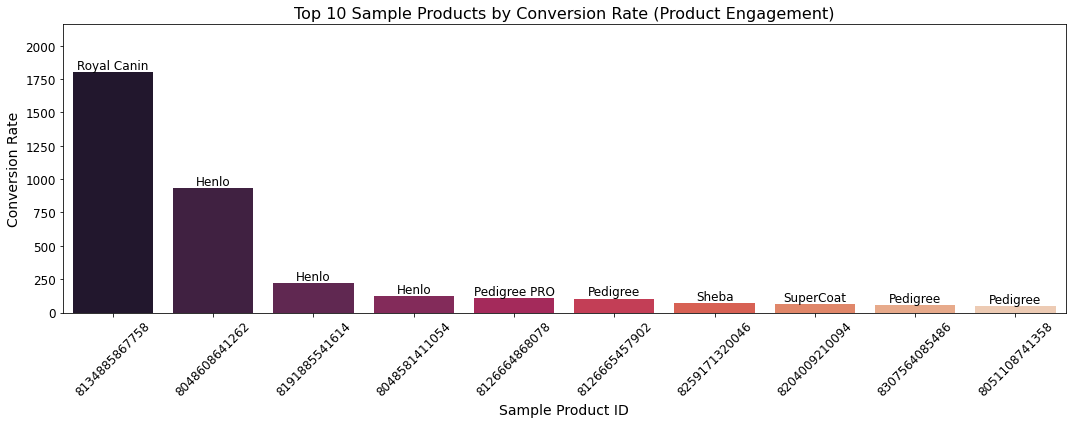

In [87]:
# Set up figure size
plt.figure(figsize=(15, 6))

# Create bar plot
ax = sns.barplot(
    data=top10_products, 
    x='sampleProductId', 
    y='product_engagement', 
    palette='rocket', 
    order=top10_products['sampleProductId']  # Ensure order follows descending sorting
)

# Plot styling
plt.title('Top 10 Sample Products by Conversion Rate (Product Engagement)', fontsize=16)
plt.xlabel('Sample Product ID', fontsize=14)
plt.ylabel('Conversion Rate', fontsize=14)
plt.ylim(0, top10_products['product_engagement'].max() * 1.2)  # Extra space for annotations
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Annotate each bar with the associated company (brand)
for bar, (_, row) in zip(ax.patches, top10_products.iterrows()):
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.02, 
        f"{row['brand']}",
        ha='center', va='bottom', fontsize=12, color='black'
    )

# Adjust layout for better visibility
plt.tight_layout()

# Show the plot
plt.show()


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the top 5 brands based on brand_loyalty
top_brands = ['Henlo', 'Pedigree', 'Drools', 'Royal Canin', 'Kit Cat']

# Filter sample_orders to include only these brands.
subset_orders = sample_orders[sample_orders['brand'].isin(top_brands)].copy()

# Group by both brand and sampleProductId to calculate product engagement:
# - sample_customers: unique count of customers who received that sample product
# - converted_customers: count of customers who later purchased the corresponding parent product
product_stats_by_brand = subset_orders.groupby(['brand', 'sampleProductId']).agg(
    sample_customers=('customer_id', lambda x: x.nunique()),
    converted_customers=('product_converted', lambda x: x[x==True].count())
).reset_index()

# Calculate product engagement (conversion rate)
product_stats_by_brand['product_engagement'] = product_stats_by_brand['converted_customers'] / product_stats_by_brand['sample_customers']

# For each brand, select the top 3 sample products by product_engagement
top3_products_by_brand = product_stats_by_brand.groupby('brand', group_keys=False).apply(
    lambda x: x.sort_values(by='product_engagement', ascending=False).head(3)
).reset_index(drop=True)

print("Top 3 Products by Product Engagement for each Top Brand:")
top3_products_by_brand



Top 3 Products by Product Engagement for each Top Brand:


,brand,sampleProductId,sample_customers,converted_customers,product_engagement
0,Drools,7968914899182,1228,156,0.127036
1,Drools,7716099391726,522,49,0.093870
2,Drools,8104275443950,2119,138,0.065125
3,Henlo,8048608641262,4236,39400,9.301228
4,Henlo,8191885541614,22,48,2.181818
5,Henlo,8048581411054,2810,3376,1.201423
6,Kit Cat,8084014432494,492,51,0.103659
7,Kit Cat,8084024033518,409,39,0.095355
8,Kit Cat,8084107493614,770,71,0.092208
9,Pedigree,8126665457902,169,176,1.041420


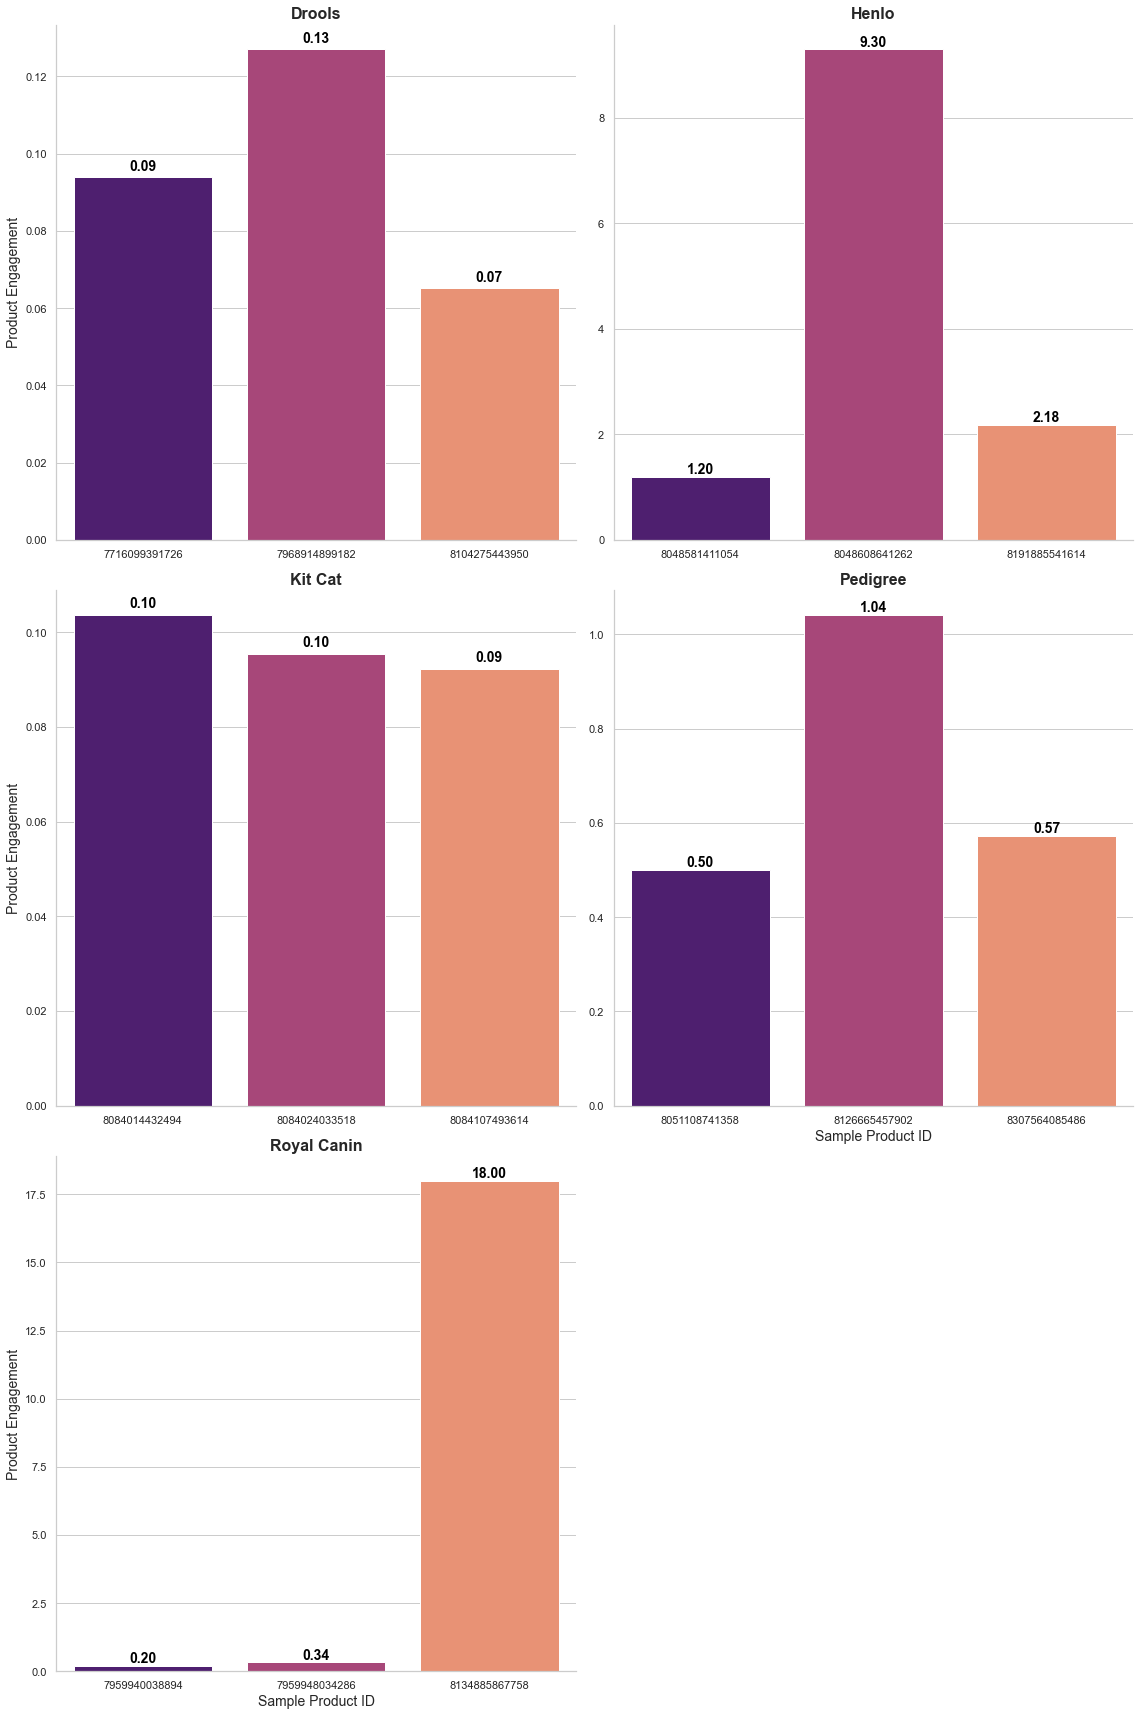

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern style
sns.set_theme(style="whitegrid")

# Visualize the results using a FacetGrid bar plot with enhanced aesthetics.
g = sns.FacetGrid(top3_products_by_brand, col="brand", col_wrap=2, height=8, sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x='sampleProductId', y='product_engagement', palette='magma')

# Set titles and axis labels with enhanced font styling.
g.set_titles(col_template="{col_name}", fontweight='bold', size=16)
g.set_axis_labels("Sample Product ID", "Product Engagement", fontsize=14)

# Annotate each bar with its conversion rate in bold, placed at the top of the bar.
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        # Place annotation exactly on top of the bar.
        ax.text(p.get_x() + p.get_width()/2, height + 0.001, f'{height:.2f}',
                ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


# TASK 3: Calculate Time to Conversion

In [55]:
# Function to compute conversion time (in hours) for the first parent purchase.
def get_conversion_time(customer, parent_id, sample_date):
    subsequent_orders = orders_df[(orders_df['customer_id'] == customer) &
                                  (orders_df['Order_date'] > sample_date) &
                                  (orders_df['productId'] == parent_id)]
    if subsequent_orders.empty:
        return np.nan
    else:
        # Find the earliest conversion order.
        first_conversion_date = subsequent_orders['Order_date'].min()
        delta = first_conversion_date - sample_date
        return delta.total_seconds() / 3600  # return conversion time in hours


In [56]:
# --- Time to Conversion ---
# Compute conversion time for each sample order (only if conversion happened)
sample_orders['conversion_time_hours'] = sample_orders.apply(lambda row: get_conversion_time(row['customer_id'], row['parentProductId'], row['Order_date']), axis=1)
# Filter out non-conversions and calculate average conversion time (in hours and days)
conversion_times = sample_orders['conversion_time_hours'].dropna()
average_conversion_hours = conversion_times.mean()
average_conversion_days = average_conversion_hours / 24
print(f"\nAverage Conversion Time: {average_conversion_hours:.2f} hours ({average_conversion_days:.2f} days)")



Average Conversion Time: 2263.65 hours (94.32 days)


In [112]:
median_conversion_hours = conversion_times.median()
median_conversion_days = median_conversion_hours / 24
print(f"Median Conversion Time: {median_conversion_hours:.2f} hours ({median_conversion_days:.2f} days)")


Median Conversion Time: 1452.78 hours (60.53 days)


In [57]:
# Convert conversion time from hours to days
sample_orders['conversion_time_days'] = sample_orders['conversion_time_hours'] / 24

# Filter out orders with no conversion (NaN conversion time)
conversion_times_days = sample_orders['conversion_time_days'].dropna()

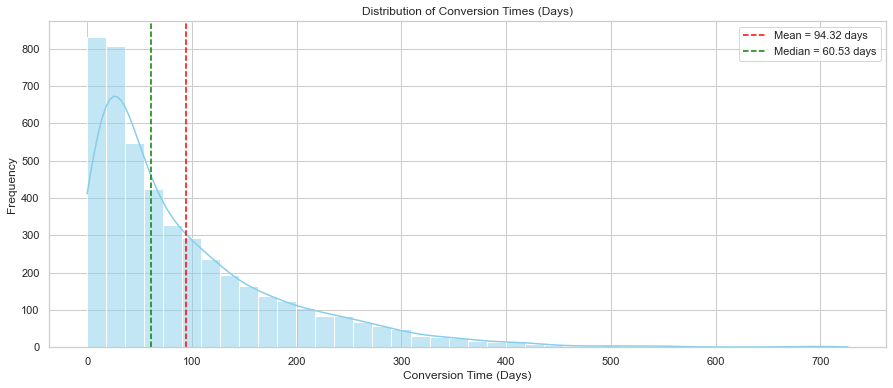

In [117]:
# Histogram and KDE for Conversion Time in Days
plt.figure(figsize=(15, 6))
# Convert hours to days for plotting
conversion_times_days = conversion_times / 24
sns.histplot(conversion_times_days, kde=True, bins=40, color='skyblue')

# Add a vertical line for the mean conversion time
plt.axvline(conversion_times_days.mean(), color='red', linestyle='--', label=f'Mean = {conversion_times_days.mean():.2f} days')

# Add a vertical line for the median conversion time
plt.axvline(median_conversion_days, color='green', linestyle='--', label=f'Median = {median_conversion_days:.2f} days')

plt.title('Distribution of Conversion Times (Days)')
plt.xlabel('Conversion Time (Days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Conclusion and Business Insights

## Conclusion

Based on the analysis of the customer purchase data and sample product conversion metrics, several key findings emerge:

- **Brand Attachment:**  
  - The top brands in terms of brand loyalty include **Henlo**, **Pedigree**, and **Drools**, with brand loyalty ratios exceeding 1.0 for these brands. This indicates that many customers who received samples from these brands went on to make additional purchases.
  
- **Product Engagement:**  
  - Within the sample products, there is significant variability in product engagement. For example, a Royal Canin sample (sampleProductId: 8134885867758) achieved an exceptional engagement rate of 18.00%, whereas other products showed much lower conversion rates.
  - The top 3 products for each top brand were identified, providing a granular view of which samples are driving conversion most effectively. Brands like **Henlo** and **Royal Canin** have sample products with high engagement, suggesting a strong connection between sampling and subsequent purchases.

- **Time to Conversion:**  
  - The average time to conversion was calculated at approximately **2263.65 hours (94.32 days)**, while the median conversion time was about **1452.78 hours (60.53 days)**.  
  - These extended conversion times suggest that customers typically take several months before transitioning from receiving a sample to making a full purchase.

## Business Insights for Supertrail

1. **Prioritize High Loyalty Brands:**  
   - With top brands such as **Henlo**, **Pedigree**, and **Drools** demonstrating strong brand loyalty, Supertrail should focus marketing and sampling efforts on these brands. Enhanced sampling campaigns and loyalty programs could further boost repeat purchases.

2. **Optimize Sample Product Offerings:**  
   - Given the marked differences in product engagement across sample products, Supertrail should analyze which samples convert best to full purchases. For instance, the outstanding performance of certain Royal Canin samples can serve as a model for promoting similar products or improving those with lower engagement rates.

3. **Shorten the Conversion Cycle:**  
   - The long conversion times indicate a delay between sampling and full purchase. To reduce this lag, Supertrail could implement targeted follow-up initiatives:
     - **Follow-Up Campaigns:** Send reminders, educational content, or special offers shortly after the sample delivery to encourage a faster decision-making process.
     - **Personalized Communication:** Leverage customer data to tailor communications that address potential concerns and highlight product benefits.
     - **Incentivization Programs:** Introduce limited-time offers or discounts to prompt quicker conversions.

4. **Data-Driven Strategy Refinement:**  
   - Regularly monitoring key metrics such as brand loyalty, product engagement, and time to conversion will provide actionable insights. Adjusting marketing strategies based on these metrics can ensure that resources are allocated effectively to maximize ROI.

5. **Enhance Customer Experience:**  
   - The insights derived suggest an opportunity to improve the overall sampling experience. By better understanding the customer journey and the time lag in conversions, Supertrail can fine-tune the sampling process to improve customer satisfaction and drive faster purchase decisions.

Overall, these findings provide a robust framework for strategic decision-making. By leveraging high-performing brands and products, and addressing the long conversion times, Supertrail can drive significant improvements in customer engagement and overall business performance.
